In [8]:
import numpy as np
import torch 
import torchvision 
from torch import nn
from sklearn.mixture import GaussianMixture
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tqdm 
import random


torch.manual_seed(1) 
np.random.seed(1) 

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [3]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())
fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [127]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray') 
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    plt.tight_layout()  

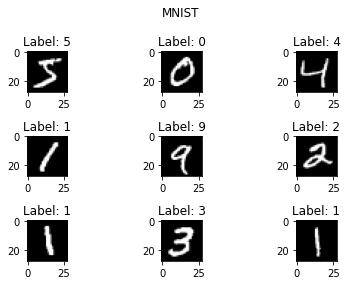

In [128]:
display_nine_images(mnist_trainset)

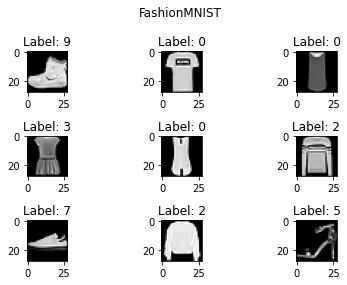

In [129]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

Vamos iniciar transformando as imagens de entrada em vetores de uma dimensão:

In [4]:
train_mnist = mnist_trainset.data.numpy()
train_mnist = train_mnist.reshape(train_mnist.shape[0], -1)
train_mnist

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Agora escolhemos nosso número de clusters (escolhemos 10 pois temos 10 dígitos) e inicializamos os centroides aleatoriamente, criando também as funções de determinar o cluster mais próximo e de atualizar os centroides:

In [131]:
# chosen k (number of clusters -> mnist has 10 digits)
k = 10

# random initialization of centroids
m, n  = np.shape(train_mnist)
centroids = np.empty((k, n))
for i in range(k):
    centroids[i] = train_mnist[random.randint(0,m)]

# get closest centroid for each data point
def get_closest_centroid(data, centroids):
    dists = np.empty((data.shape[0], k))
    for i in range(k):
        dists[:, i] = np.linalg.norm(data - centroids[i], axis=1)
    return np.argmin(dists, axis=1)

# update centroids
def update_centroids(data, closest_centroids):
    new_centroids = np.empty((k, n))
    for i in range(k):
        new_centroids[i] = np.mean(data[closest_centroids == i], axis=0)
    return new_centroids

Definimos a função de k-means, que tem como criterio de parada a não mudança dos centroides:

In [132]:
# run k-means
def k_means(data, centroids):
    closest_centroids = get_closest_centroid(data, centroids)
    new_centroids = update_centroids(data, closest_centroids)
    while not np.array_equal(centroids, new_centroids):
        centroids = new_centroids
        closest_centroids = get_closest_centroid(data, centroids)
        new_centroids = update_centroids(data, closest_centroids)
    return centroids, closest_centroids

In [133]:
centroids, closest_centroids = k_means(train_mnist, centroids)

Definimos também funções para reconhecer qual a label mais comum em cada centroide:

In [134]:
# get most common label for each cluster
def get_most_common_label(data, closest_centroids):
    labels = {}
    for i in range(k):
        labels[i] = np.argmax(np.bincount(data[closest_centroids == i]))
    return labels

labels = get_most_common_label(mnist_trainset.targets, closest_centroids)

In [135]:
# map the closest cetroinds to the labels
def map_labels(closest_centroids, labels):
    mapped_labels = np.empty_like(closest_centroids)
    for i in range(k):
        mapped_labels[closest_centroids == i] = labels[i]
    return mapped_labels

mapped_labels = map_labels(closest_centroids, labels)

E então criamos a matriz de confusão para ver como os clusters se relacionam com as labels, utilizando as funções anteriores para mapear corretamente os clusters às labels:

Text(0.5, 1.0, 'Confusion matrix for MNIST dataset - random initialization')

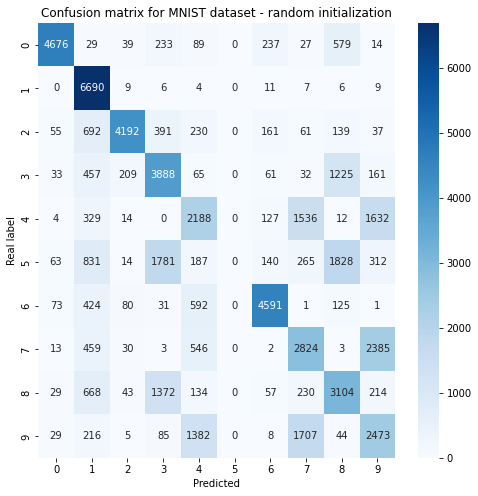

In [136]:
conf_matrix = confusion_matrix(mnist_trainset.targets, mapped_labels)
fig = plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real label')
plt.title('Confusion matrix for MNIST dataset - random initialization')

Vejamos também samples de que tipo de imagem cada cluster representa:

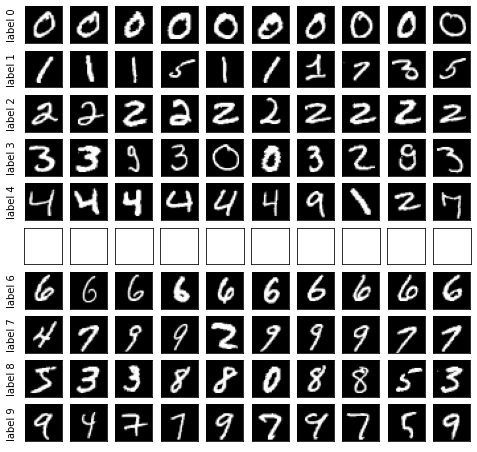

In [163]:
def plot_sample(data, mapped_labels):
    fig, ax = plt.subplots(k, 10, figsize=(8, 8))
    for i in range(k):
        for j in range(10):
            if len(data.data[mapped_labels == i]) >= 10:
                ax[i, j].imshow(data.data[mapped_labels == i][j], cmap='gray')
                if j == 0:
                    ax[i, j].set_ylabel(f'label {mapped_labels[mapped_labels == i][j]}')
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()

plot_sample(mnist_trainset, mapped_labels)

Observe que, apesar de não serem perfeitos, os clusters representam bem os dígitos, com poucas exceções. É interessante notar, também, que não há um cluster para o número 5, que acabou não sendo representado por nenhum cluster, e sim distribuído entre os outros clusters (vemos amostrar no 1 e no 8, por exemplo).

Agora faremos o processo novamente, mas inicializando os centroides de acordo com a estraégia do k-means++:

In [164]:
# kmeans++ initialization
centroids = np.empty((k, n))
centroids[0] = train_mnist[random.randint(0,m)]
for i in range(1, k):
    dists = np.empty((train_mnist.shape[0], i))
    for j in range(i):
        dists[:, j] = np.linalg.norm(train_mnist - centroids[j], axis=1)
    min_dist = np.min(dists, axis=1)
    probs = min_dist / np.sum(min_dist)
    centroids[i] = train_mnist[np.random.choice(train_mnist.shape[0], p=probs)]

In [165]:
centroids, closest_centroids = k_means(train_mnist, centroids)

Plotamos novamente a confusão e os samples:

Text(0.5, 1.0, 'Confusion matrix for MNIST dataset - kmeans++ initialization')

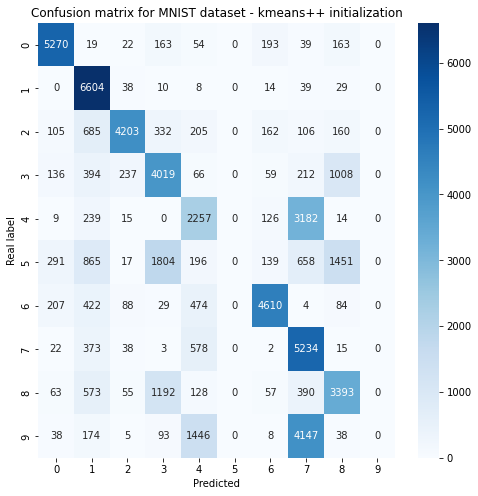

In [166]:
labels = get_most_common_label(mnist_trainset.targets, closest_centroids)
mapped_labels = map_labels(closest_centroids, labels)

conf_matrix = confusion_matrix(mnist_trainset.targets, mapped_labels)
fig = plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real label')
plt.title('Confusion matrix for MNIST dataset - kmeans++ initialization')

Observe que, apesar da estratégia de tentar inicializar os centroides de forma mais espalhada, o resultado não foi muito diferente do anterior, e inclusive não tivemos um cluster para o número 9 também.

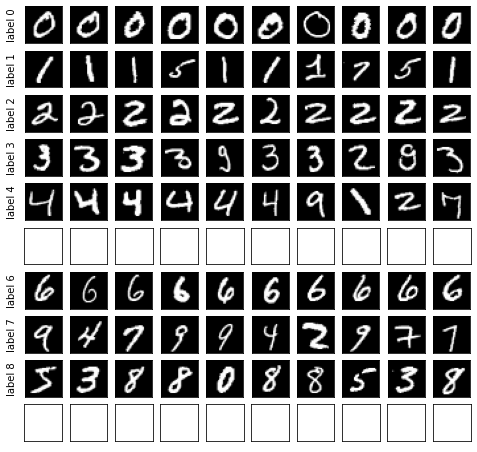

In [167]:
plot_sample(mnist_trainset, mapped_labels)

Por fim, faremos o processo novamente, mas inicializando os centroides como as médias das imagens de cada classe:

In [168]:
# initialize centroids with average image of each class 
centroids = np.empty((k, n))
for i in range(k):
    centroids[i] = np.mean(train_mnist[mnist_trainset.targets == i], axis=0)

centroids, closest_centroids = k_means(train_mnist, centroids)    

Plotamos novamente a confusão e os samples:

Text(0.5, 1.0, 'Confusion matrix for MNIST dataset - kmeans++ initialization')

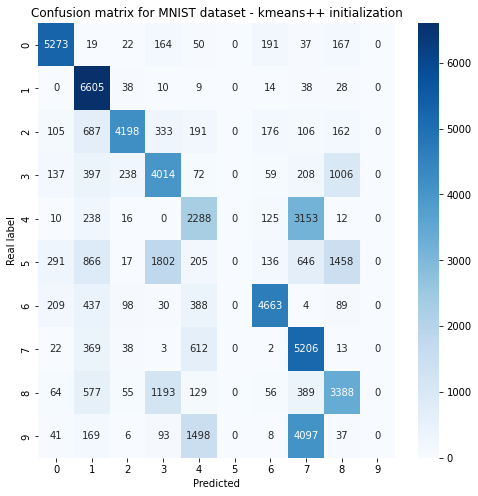

In [169]:
labels = get_most_common_label(mnist_trainset.targets, closest_centroids)
mapped_labels = map_labels(closest_centroids, labels)

conf_matrix = confusion_matrix(mnist_trainset.targets, mapped_labels)
fig = plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real label')
plt.title('Confusion matrix for MNIST dataset - kmeans++ initialization')

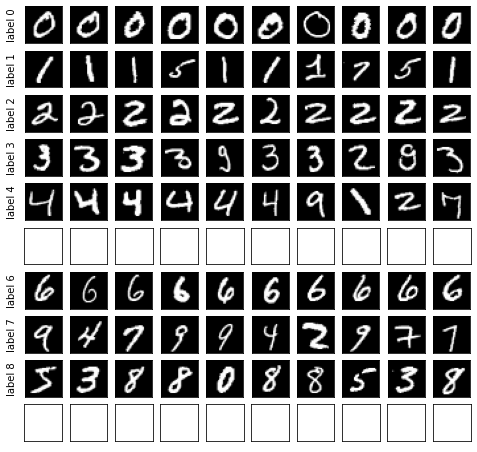

In [170]:
plot_sample(mnist_trainset, mapped_labels)

Obtivemos um resultado parecido com o do k-means++, sem clusters para o 5 e o 9, mas com uma matriz de confusão que representa muitos acertos para os outros dígitos, e samples que representam bem os números. Em geral, observamos que imagens semelhantes de fato são clusterizadas, e até os erros parecem bem justificados, principalmente ao vermos os samples, já que, por exemplo, o número 9 é bastante parecido em formato com o 7 em muitos casos.

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente, treine um MLP para classificar o MNIST. Com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino). Agora, avalie a capacidade dessa GMM diferenciar amostras de test do MNIST e do FashionMNIST (espera-se que amostras OOD --- do Fashin MNIST--- estejam nas caudas). Teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. Para simplificar sua vida, use a implementação de GMM do scikit-learn.

Vamos inicialmente definindo um MLP simples para classificar o MNIST:

In [36]:
mnist_train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 512)
        self.r1 = nn.ReLU()
        self.l2 = nn.Linear(512, 512)
        self.r2 = nn.ReLU()
        #self.l3 = nn.Linear(256, 256)
        #self.r3 = nn.ReLU()
        self.l4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.r1(x)
        x = self.l2(x)
        #x = self.r2(x)
        #x = self.l3(x)
        activation = self.r2(x)
        x = self.l4(activation)
        return x, activation
    
mlp = MLP()

Treinamos o modelo e definimos também a função de teste, que levará em conta o GMM:

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.0001)

def train(dataloader, model, loss_fn, optimizer):
    global activation
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred, activation = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model_mlp, model_gmm, threshold):
    global activation_test
    ood_count = 0
    size = len(dataloader.dataset)
    model_mlp.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            prediction, activation_test = model_mlp(X)
            loglik = model_gmm.score_samples(np.reshape(activation_test.detach().numpy()[-1], (-1,1)))
            if (loglik < threshold).any():
                ood_count += 1
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%')
    print(f'OOD: {ood_count}')

epochs = 5
for t in range(epochs):
    train(mnist_train_dataloader, mlp, loss_fn, optimizer)

Agora que o GMM está definido, podemos testar o GMM para modelar as ativações da penúltima camada do MLP, e avaliar a acurácia e número de amostras reconhecidas como OOD quando testamos o modelo com o MNIST apenas:

In [56]:
gmm = GaussianMixture(10)
act_fit = np.reshape(activation.detach().numpy()[-1], (-1,1))
gmm.fit(act_fit)

threshold = np.min(gmm.score_samples(act_fit))
test(mnist_test_dataloader, mlp, gmm, threshold)

Accuracy: 76.9%
OOD: 49


Observe que tivemos uma boa acurácia e um número pequeno de amostras reconhecidas como OOD, o que é um bom sinal, já que não introduzimos imagens de objetos não vistos no treino. Vamos agora testar o modelo com uma combinação de MNIST e FashionMNIST:

In [58]:
both_tests = torch.utils.data.ConcatDataset([mnist_trainset, fashion_mnist_trainset])
dataloader_both = DataLoader(both_tests, batch_size=64, shuffle=True)

test(dataloader_both, mlp, gmm, threshold)

Accuracy: 40.3%
OOD: 695


É interessante observar que, obviamente, obtivemos uma acurácia menor, já que o modelo não foi treinado com imagens de FashionMNIST, e também que o número de amostras reconhecidas como OOD aumentou, o que é um bom sinal, já que introduzimos imagens de objetos não vistos no treino. O que buscávamos, de fato, era que o modelo reconhecesse mais imagens como OOD (não vistas antes, e portanto out of distribution), e isso foi obtido.

Vamos, por fim, testar nosso modelo com diferentes números de componentes das misturas, e ver qual provê a melhor separação:

In [61]:
# testing different components

for i in range(1, 11):
    print(f'Number of components: {i}')
    gmm = GaussianMixture(i)
    act_fit = np.reshape(activation.detach().numpy()[-1], (-1,1))
    gmm.fit(act_fit)
    threshold = np.min(gmm.score_samples(act_fit))
    test(dataloader_both, mlp, gmm, threshold)
    

Number of components: 1
Accuracy: 40.3%
OOD: 678
Number of components: 2
Accuracy: 40.3%
OOD: 684
Number of components: 3
Accuracy: 40.3%
OOD: 680
Number of components: 4
Accuracy: 40.3%
OOD: 685
Number of components: 5
Accuracy: 40.3%
OOD: 727
Number of components: 6
Accuracy: 40.3%
OOD: 675
Number of components: 7
Accuracy: 40.3%
OOD: 661
Number of components: 8
Accuracy: 40.3%
OOD: 665
Number of components: 9
Accuracy: 40.3%
OOD: 699
Number of components: 10
Accuracy: 40.3%
OOD: 654


In [64]:
# number of labels fashion mnist
fashion_mnist_trainset.targets.shape

torch.Size([60000])

Observe que a melhor separação de amostras OOD foi obtida com 5 componentes, e portanto consideramos essa versão (dentre as testadas), a melhor em separar amostras, já que sabemos que o tamanho do tamanho do conjunto de teste do Fashion MNIST é 60000, e como treinamos apenas no MNIST, quanto mais dessas amostras forem classificadas como out of distribution, melhor. 

## Exercício de "papel e caneta"

**1.** Como vimos anteriormente, a função custo para $k$-means é:
$$
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
$$
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em:
$$
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}
$$
Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



**Resposta:**

Para otimizar a função de custo quando não conhecemos todas as labels, faremos algo parecido com o que ocorre para derivarmos o k-means, que é uma otimização utilizando os passos E e M do algoritmo EM. O nosso passo E representa a definição de um cluster de pontos partindo do fato de que temos um centroide $\mu_i$, enquanto o passo M representa a redefinição de um centroide partindo do fato de que temos um cluster de pontos $C_i$.


Vamos reescrever a função de custo passando a tratar o pertencimento ao cluster $C_i$ como uma variável indicatriz $r_{nk}$. Então temos:
$$
\sum_{n=1\ldots N} \sum_{k=1 \ldots K} r_{nk} \mathbb{E}_{x_{n M(x_n)} \sim N\left(0, c I_{|M(x_n)|}\right)}\big[\| x_n - \mu_k \|_2^2\big],
$$

**Passo E:** como queremos redefinir o cluster de pontos partindo do fato de que temos um centroide $\mu_i$, então queremos encontrar os pontos que minimizam a distância de cada centroide. Para isso, vamos atribuir valor 1 para o cluster que minimiza a distância de cada ponto, e 0 para os demais. Então temos:

$$
r_{nk} = \begin{cases}
1, & \text{se } k = \arg\min_j\mathbb{E}_{x_{n M(x_n)} \sim N\left(0, c I_{|M(x_n)|}\right)} \big[ \| x_n - \mu_j \|_2^2 \big]\\
0, & \text{caso contrário}
\end{cases}
$$

Observe que esse valor esperado, quando temos $x_n$ como um valor conhecido, é igual a $(x_n - \mu_j)^2$, e quando temos $x_n$ como um valor desconhecido, basta perceber que $\mathbb{E}\big[ \| x_n - \mu_j \|_2^2 \big] = Var[x_n - \mu_j] + \mathbb{E}[x_n - \mu_j]^2 = \mu_j^2 + c$.


**Passo M:** como queremos redefinir o centroide partindo do fato de que temos um novo cluster de pontos, queremos encontrar $\mu_k$ tendo $r_{nk}$ fixo. Então vamos derivar em relação a $\mu_k$ e igualar a zero. Temos:	

$$
\frac{\partial}{\partial \mu_k} \sum_{n=1\ldots N} \sum_{k=1 \ldots K} r_{nk} \mathbb{E}_{x_{n M(x_n)} \sim N\left(0, c I_{|M(x_n)|}\right)}\big[\| x_n - \mu_k \|_2^2\big] = 0
$$

$$
2\sum_{n=1\ldots N} r_{nk} \mathbb{E}_{x_{n M(x_n)} \sim N\left(0, c I_{|M(x_n)|}\right)}\big[x_n - \mu_k \big] = 0
$$

$$
\mu_k = \frac{\sum_{n=1\ldots N} r_{nk} \mathbb{E}_{x_{n M(x_n)} \sim N\left(0, c I_{|M(x_n)|}\right)}\big[x_n\big]}{\sum_{n=1\ldots N} r_{nk}}
$$

Quando realizarmos o valor esperado de $x_n$, teremos sempre 0 para as entradas faltantes $(x \in M(x))$, pois estamos considerando uma distribuição Gaussiana com média 0 e variância $c$ para cada $x_m \forall m \in M(x)$, e o valor observado para as entradas não faltantes $(x \in O(x))$.

Com isso, temos um algoritmo iterativo em que definimos um centroide inicial e depois passamos pelos passos E e M até que a função de custo não mude mais. O algoritmo é o seguinte:

1. Defina um centroide inicial $\mu_k$ para cada cluster $k$.

2. Enquanto a função de custo mudar:

    2.1. Para cada ponto $n$, calcule $r_{nk}$ de acordo com o passo E.
    
    2.2. Para cada cluster $k$, calcule $\mu_k$ de acordo com o passo M, considerando $r_{nk}$ fixo, e levando em conta o cálculo mencionado acima do valor esperado de $x_n$.

É importante observar que, como temos pontos com entradas faltantes, nosso algoritmo difere do k-means original no passo E, em que não podemos simplesmente calcular a distância entre os pontos e os centroides, pois não temos todas as entradas. Então, para calcular a distância, precisamos calcular a esperança da distância entre os pontos e os centroides, considerando a distribuição de probabilidade das entradas faltantes. Além disso, no passo M, também precisamos calcular a esperança dos pontos para encontrar os novos centroides.

**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 do _Pattern Recognition and Machine Learning_ (C. Bishop) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

**Resposta:**

Vamos partir da distribuição de mistura Gaussiana:

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)
$$

onde $0 \leq \pi_k \leq 1$ e $\sum_{k=1}^K \pi_k = 1$. Vamos assumir que temos $N$ observações $\mathbf{x}_1, \ldots, \mathbf{x}_N$ e queremos encontrar os parâmetros $\pi_k, \boldsymbol{\mu}_k, \mathbf{\Sigma}_k$ que maximizam a verossimilhança:

$$  
p(\mathbf{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma}) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)
$$

onde $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$.

Vamos definir a função de custo $J$ como a log-verossimilhança:

$$
J(\boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma}) = \log p(\mathbf{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \mathbf{\Sigma}) = \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)
$$

Vamos definir também $r_{nk}$ como a responsabilidade do cluster $k$ para o ponto $n$:

$$
r_{nk} = \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \mathbf{\Sigma}_j)}
$$

Para maximizar $J$, vamos utilizar o método de _coordinate ascent_, em que vamos maximizar $J$ em relação a um parâmetro por vez, mantendo os outros fixos. Vamos começar com $\boldsymbol{\mu}_k$.

$$
\frac{\partial J}{\partial \boldsymbol{\mu}_k} = 0
$$

$$
\frac{\partial}{\partial \boldsymbol{\mu}_k} \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\partial}{\partial \boldsymbol{\mu}_k} \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{1}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} \frac{\partial}{\partial \boldsymbol{\mu}_k} \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} \frac{\partial}{\partial \boldsymbol{\mu}_k} \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}  \frac{\partial}{\partial \boldsymbol{\mu}_k} \left( -\frac{1}{2} \log |\mathbf{\Sigma}_k| - \frac{1}{2} (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \mathbf{\Sigma}_k^{-1} (\mathbf{x}_n - \boldsymbol{\mu}_k) \right) = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) }{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} (\mathbf{x}_n - \boldsymbol{\mu}_k) \mathbf{\Sigma}_k^{-1}= 0
$$

$$
\sum_{n=1}^N r_{nk}  (\mathbf{x}_n - \boldsymbol{\mu}_k) \mathbf{\Sigma}_k^{-1}= 0
$$

$$
\sum_{n=1}^N r_{nk} \mathbf{x}_n= \sum_{n=1}^N r_{nk}  \boldsymbol{\mu}_k
$$

$$
\boldsymbol{\mu}_k = \frac{\sum_{n=1}^N r_{nk}  \mathbf{x}_n}{\sum_{n=1}^N r_{nk}}
$$

Agora vamos maximizar $J$ em relação a $\mathbf{\Sigma}_k$.

$$
\frac{\partial J}{\partial \mathbf{\Sigma}_k} = 0
$$

$$
\frac{\partial}{\partial \mathbf{\Sigma}_k} \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\partial}{\partial \mathbf{\Sigma}_k} \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{1}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} \frac{\partial}{\partial \mathbf{\Sigma}_k} \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} \frac{\partial}{\partial \mathbf{\Sigma}_k} \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}  \left( -\frac{1}{2} (\mathbf{\Sigma}_k^{-1}\mathbf{\Sigma}_k^{-1} - \mathbf{\Sigma}_k^{-1}  (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \mathbf{\Sigma}_k^{-1} ) \right) = 0
$$

$$
-\frac{1}{2} \sum_{n=1}^{N}{r_{nk}}(\mathbf{\Sigma}_k^{-1}\mathbf{\Sigma}_k^{-1} - \mathbf{\Sigma}_k^{-1}  (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \mathbf{\Sigma}_k^{-1} ) = 0
$$

$$
\sum_{n=1}^{N}{r_{nk}}\mathbf{\Sigma}_k^{-1} = \sum_{n=1}^{N}{r_{nk}} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \mathbf{\Sigma}_k^{-1}
$$

$$
\mathbf{\Sigma}_k = \frac{\sum_{n=1}^{N}{r_{nk}} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T}{\sum_{n=1}^{N}{r_{nk}}}
$$


Agora vamos maximizar $J$ em relação a $\pi_k$. Como $\sum_{k=1}^K \pi_k = 1$, vamos usar multiplicadores de Lagrange.

$$
\frac{\partial}{\partial \pi_k} \left( J + \lambda \left( \sum_{k=1}^K \pi_k - 1 \right) \right) = 0
$$

$$
\frac{\partial}{\partial \pi_k} \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) + \lambda \frac{\partial}{\partial \pi_k} \left( \sum_{k=1}^K \pi_k - 1 \right) = 0
$$

$$
\sum_{n=1}^N \frac{\partial}{\partial \pi_k} \log \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) + \lambda = 0
$$

$$
\sum_{n=1}^N \frac{1}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} \frac{\partial}{\partial \pi_k} \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k) + \lambda = 0
$$

$$
\sum_{n=1}^N \frac{\mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} + \lambda = 0
$$

$$
\sum_{n=1}^N \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \mathbf{\Sigma}_k)} + \lambda = 0
$$

$$
\frac{N_k}{\pi_k} + \lambda = 0
$$

$$
\pi_k = -\frac{N_k}{\lambda}
$$

Resolvemos tanto para $\pi_k$ quanto para $\lambda$:

$$
\frac{\partial}{\partial \lambda} = 0
$$

$$
\sum_{k=1}^K \pi_k- 1 =0
$$

Agora, substituindo:


$$
-\frac{1}{\lambda} \sum_{k=1}^K N_k = 1
$$

$$
\lambda = -\sum_{k=1}^K N_k
$$

$$
\lambda = -N
$$

E substituindo novamente:

$$
\pi_k = \frac{N_k}{N}
$$

Assim, temos as seguintes equações para atualizar os parâmetros:

$$
\boldsymbol{\mu}_k = \frac{\sum_{n=1}^{N}{r_{nk}} \mathbf{x}_n}{\sum_{n=1}^{N}{r_{nk}}}
$$

$$
\mathbf{\Sigma}_k = \frac{\sum_{n=1}^{N}{r_{nk}} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T}{\sum_{n=1}^{N}{r_{nk}}}
$$

$$
\pi_k = \frac{\sum_{n=1}^N r_{nk}}{N}
$$

